In [1]:
ENV = "Meg"
datadir = './tmp'
libdir = './archive/lib'
outputdir = '.'
otherdir = './archive'

## Imports 导入相关库

In [2]:
import sys
import os
sys.path.append(f"{libdir}/timm_effnetv2")
os.environ['TORCH_HOME']='./archive/torch_cache/'
import pandas as pd
import numpy as np

import sys
import time
import cv2
import PIL.Image
import random
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import albumentations
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import roc_auc_score
%matplotlib inline
import seaborn as sns
from pylab import rcParams
import timm
from warnings import filterwarnings
from sklearn.preprocessing import LabelEncoder
import math
import glob
from torch.nn import DataParallel
from collections import OrderedDict
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler
from sklearn.metrics import average_precision_score
from pprint import pprint
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score
filterwarnings("ignore")
device = torch.device('cuda')

In [3]:
pick_params_d = {}
def pick_params(param_name, candidate):
    for _ in range(int(str(round(time.time() * 1000))[-2:])):
        random.random()
    time.sleep(random.random())
    value = random.choice(candidate)
    pick_params_d[param_name] = (value,candidate)
    return value

In [4]:
# 设置随机种子，以便实验复现
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # set True to be faster
seed_everything(53) ####

def get_timediff(time1,time2):
    minute_,second_ = divmod(time2-time1,60)
    return f"{int(minute_):02d}:{int(second_):02d}"  
    
    
def init_logger(log_file=outputdir+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger(f'{outputdir}/train.log')

## Configuration

In [16]:
# 配置参数和模型超参数
class CFG:
    train_bs = 32 # 训练集batch_size，请根据GPU性能调整
    valid_bs = 64 # 验证集batch_size，请根据GPU性能调整
    n_worker = 24 # 数据导入线程数，请根据CPU性能调整
    gpu_parallel= True # 是否启用多个GPU，请根据GPU性能调整

    suffix = "9999" # 本次实验id
    fold_id = [0,1,2,3,4]
    image_size = 512 # 图片尺寸
    model_arch = "tf_efficientnetv2_l_in21k" # tf_efficientnetv2_m, tf_efficientnetv2_l_21k  tf_efficientnetv2_l
    n_epochs = 10 ###
    max_early_stop = 3

    loss_fn = "FocalLoss" ### CustomLoss BCEWithLogitsLoss FocalLoss CrossEntropyLoss
    focal_alpha = 0.6; focal_gamma = 1.8; ###
    loss_aux = "binary_cross_entropy"
    loss1_coef = 1 ###
    optimizer = "AdamW"
    scheduler = "CosineAnnealingLR"
    scheduler_warmup = None # "GradualWarmupSchedulerV3" 
    warmup_factor = 2; warmup_epo = 5; T_max= n_epochs-warmup_epo-1 if scheduler_warmup=="GradualWarmupSchedulerV3" else n_epochs-1
    
    init_lr = 2.412396e-4 ###
    min_lr = 2.570752e-7 ###
    weight_decay = 2.133535e-3 ###
    drop_rate = 0.45 ###
    drop_path_rate = 0.1 ###
    
    debug = False

## Read CSV & Make Folds

In [17]:
train_image = pd.read_csv(f"{datadir}/train_image_level.csv")
train_study = pd.read_csv(f"{datadir}/train_study_level.csv")
TRAIN_DIR = f"{datadir}/train/image"

train_unique_study_image = pd.DataFrame([],columns=["id","boxes","label","StudyInstanceUID"])

old_study_list = []
old_boxes_list = []
cnt = 0
for idx, image_id, boxes, df_label, StudyInstanceUID in train_image.itertuples():
    if StudyInstanceUID not in old_study_list:
        old_study_list.append(StudyInstanceUID)
        if df_label != "none 1 0 0 1 1":
            old_boxes_list.append(StudyInstanceUID)
        train_unique_study_image = train_unique_study_image.append(pd.DataFrame([[image_id, boxes, df_label, StudyInstanceUID]], columns=["id","boxes","label","StudyInstanceUID"]))
    else:    
        if StudyInstanceUID in old_boxes_list:
            continue
        else: # StudyInstanceUID not in old_boxes_list
            if df_label != "none 1 0 0 1 1":
                old_boxes_list.append(StudyInstanceUID)
                train_unique_study_image.loc[train_unique_study_image["StudyInstanceUID"] == StudyInstanceUID,["id","boxes","label","StudyInstanceUID"]] = [image_id, boxes, df_label, StudyInstanceUID]

train_unique_study_image = train_unique_study_image[["StudyInstanceUID","id"]].reset_index(drop=True)
# train_unique_study_image = train_unique_study_image[["StudyInstanceUID","id","label"]].reset_index(drop=True)

# train_unique_study_image = train_image.groupby("StudyInstanceUID").first()["id"].reset_index()
train_study['StudyInstanceUID'] = train_study['id'].apply(lambda x: x.replace('_study', ''))
df_train = train_study.merge(train_unique_study_image, on='StudyInstanceUID')
# Make a path folder
df_train['file_path'] = df_train["id_y"].apply(lambda x:TRAIN_DIR + "/" + x + ".png")
df_train = df_train.drop(['id_x', 'id_y'], axis=1)
df_train.head()

# 做5fold切分数据，并把每行归属的fold加入到df_train中
gkf = GroupKFold(n_splits=5) 
df_train['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(gkf.split(df_train, groups = df_train.StudyInstanceUID.tolist())):
    df_train.loc[valid_idx, 'fold'] = fold

In [18]:
df_train

,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,StudyInstanceUID,file_path,fold
0,0,1,0,0,00086460a852,./tmp/train/image/65761e66de9f_image.png,3
1,0,0,0,1,000c9c05fd14,./tmp/train/image/51759b5579bc_image.png,4
2,1,0,0,0,00292f8c37bd,./tmp/train/image/f6293b1c49e2_image.png,0
3,1,0,0,0,005057b3f880,./tmp/train/image/3019399c31f4_image.png,1
4,0,0,0,1,0051d9b12e72,./tmp/train/image/bb4b1da810f3_image.png,2
...,...,...,...,...,...,...,...
6049,0,1,0,0,ffcb4630f46f,./tmp/train/image/84ed5f7f71bf_image.png,2
6050,0,1,0,0,ffe4d6e8fbb0,./tmp/train/image/e6215d0188e5_image.png,3
6051,0,1,0,0,ffe94fcb14fa,./tmp/train/image/7d27b1bb3987_image.png,4
6052,0,1,0,0,ffebf1ef4a9c,./tmp/train/image/52478e480a15_image.png,4


## Transforms 数据增强

In [19]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, CLAHE, RandomRotate90,
    Transpose, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, 
    CenterCrop, Resize, RandomCrop, GaussianBlur, JpegCompression, Downscale, ElasticTransform, ImageCompression
)
import albumentations
from albumentations.pytorch import ToTensorV2


augs = {
    "HorizontalFlip_p": 0.5,# 水平翻转
    "ShiftScaleRotate_p":0.7,   # 平移、缩放、旋转
    "shift_limit":0.03,  # 平移比例
    "scale_limit":0.7,  # 缩放比例
    "rotate_limit":40,  # 旋转比例
    "Cutout_p":0.7,  # Cutout增强
    "num_holes":9,  # Cutout网格数量
    "max_hw_size":0.06,  # Cutout网格大小
    
    "RandomBrightnessContrast_p":0.1,   # 亮度、对比度
    "brightness_limit":0.3,   # 亮度比例
    "contrast_limit":0.3,     # 对比度比例
    "HueSaturationValue_p":0.1,   # 色相、饱和度、明度
    "hue_shift_limit":20,   # 色相比例
    "sat_shift_limit":50,   # 饱和度比例
    "val_shift_limit":40,   # 明度比例
}

transforms_train = Compose([
            RandomCrop(CFG.image_size, CFG.image_size),
            HorizontalFlip(p=augs["HorizontalFlip_p"]), 
            ShiftScaleRotate(p=augs["ShiftScaleRotate_p"], shift_limit=augs["shift_limit"], scale_limit=augs["scale_limit"], rotate_limit=augs["rotate_limit"]), 
            Cutout(p=augs["Cutout_p"], num_holes=augs["num_holes"], max_h_size=int(CFG.image_size*augs["max_hw_size"]), max_w_size=int(CFG.image_size*augs["max_hw_size"])),      
            ],
            additional_targets={'image0': 'image'})

transforms_train_nomask = Compose([
            RandomBrightnessContrast(p=augs["RandomBrightnessContrast_p"], brightness_limit=augs["brightness_limit"], contrast_limit=augs["contrast_limit"]),
            HueSaturationValue(p=augs["HueSaturationValue_p"], hue_shift_limit=augs["hue_shift_limit"], sat_shift_limit=augs["sat_shift_limit"], val_shift_limit=augs["val_shift_limit"]),     
            Normalize() 
            ],)

transforms_valid = Compose([
    Resize(CFG.image_size, CFG.image_size),
    Normalize() 
])

## Dataset

In [20]:
class SIIMDataset(Dataset):
    def __init__(self, df, mode, transform=None):
        self.df = df.reset_index(drop=True)
        self.mode = mode # 数据集模式（train模式或test模式）
        self.transform = transform # 数据增强

    def __len__(self):
        return len(self.df) # 获取dataframe行数

    def __getitem__(self, index):
        row = self.df.loc[index] # 获取指定（index）行
        img = cv2.imread(row.file_path) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.mode == "train":
            mask_img = cv2.imread(row.file_path.replace("rsna512png", "rsna512png_mask").replace("train512png", "train512png_mask"))
            mask_img = cv2.cvtColor(mask_img, cv2.COLOR_BGR2RGB)

        # 如果有数据增强，则做数据增强
        if self.transform is not None: 
            if self.mode == "train":
                transform_img  = self.transform(image=img, image0=mask_img)
                img = transforms_train_nomask(image=transform_img['image'])["image"]
                mask_img = transform_img['image0']
                mask_img = mask_img.transpose(2,0,1).astype(np.float32)
                mask_img = mask_img/255
            else:
                img = self.transform(image=img)["image"]
                
        # 调整一下数据格式
        img = img.transpose(2,0,1).astype(np.float32)
        # img = img/255; 

        # 返回 获取到的图片
        if self.mode == 'train':
            return torch.tensor(img).float(), torch.tensor(mask_img).float(), torch.tensor(row[['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']]).float()
        elif self.mode == 'valid':
            return torch.tensor(img).float(), torch.tensor(row[:4]).float()
        elif self.mode == 'test':
            return torch.tensor(img).float()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

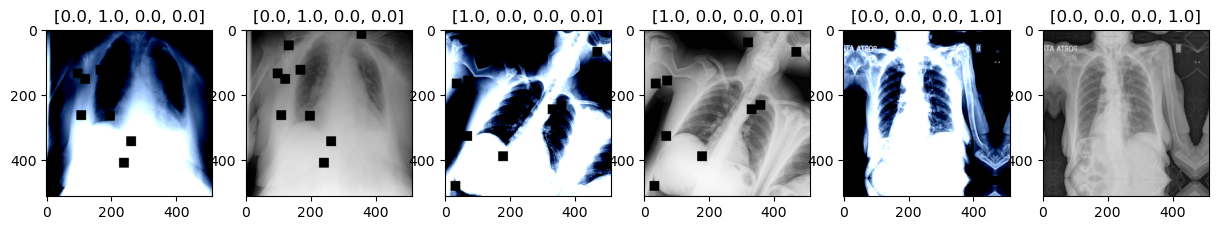

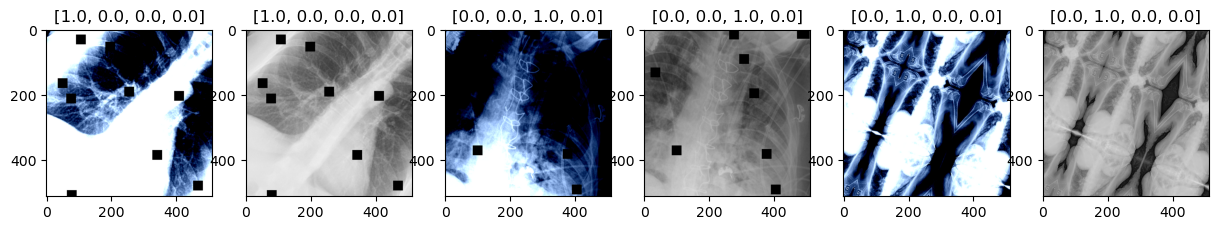

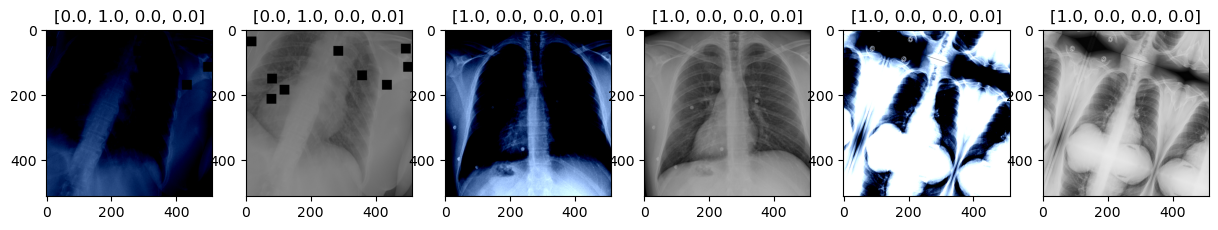

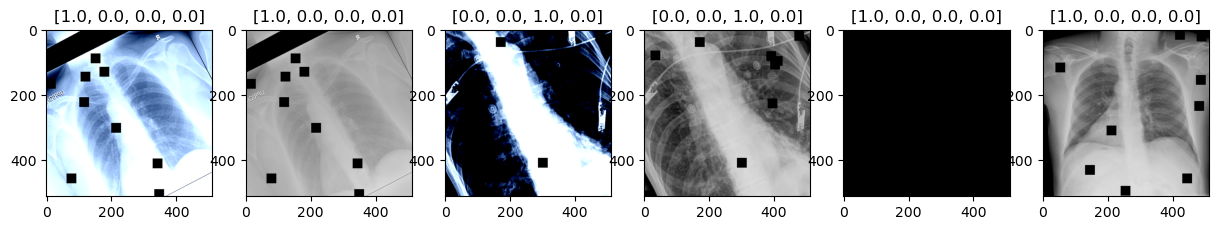

In [21]:
# 先看一下数据集返回的图片长什么样子
dataset = SIIMDataset(df_train, 'train', transform = transforms_train)
rcParams['figure.figsize'] = 15,5
for i in range(4):
    f, axarr = plt.subplots(1,6)
    for p in range(0,6,2):
        idx = i*5 + p
        img, mask_img, label = dataset[idx]
        axarr[p].imshow(img.transpose(0,1).transpose(1,2).squeeze())
        axarr[p+1].imshow(mask_img.transpose(0,1).transpose(1,2).squeeze())
        axarr[p].set_title(label.tolist())
        axarr[p+1].set_title(label.tolist())

## Model

In [22]:
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes=4, model_arch=CFG.model_arch, pretrained=True):
        super(EfficientNetModel, self).__init__()
        e = timm.create_model(model_arch, pretrained=pretrained, drop_rate=CFG.drop_rate, drop_path_rate=CFG.drop_path_rate)
        
        self.logit = nn.Linear(e.classifier.in_features, num_classes)
        self.e1 = nn.Sequential(e.conv_stem, e.bn1, e.act1,)
        
        self.b0 = e.blocks[0]
        self.b1 = e.blocks[1]
        self.b2 = e.blocks[2]
        self.b3 = e.blocks[3]
        self.b4 = e.blocks[4] # channel = 224
        self.b5 = e.blocks[5]
        self.b6 = e.blocks[6]
        
        self.mask = nn.Sequential(
            nn.Conv2d(224, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=1, padding=0),
        )
        self.e2 = nn.Sequential(e.conv_head, e.bn2, e.act2,)

    def forward(self, x):
        batch_size = len(x)
        x = self.e1(x)
        x = self.b0(x)
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        # ==========================
        mask = self.mask(x) # mask操作
        # ==========================
        x = self.b5(x)
        x = self.b6(x)
        x = self.e2(x)
        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        logit = self.logit(x)

        return logit, mask

## Utils

In [23]:
# 训练函数
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()
def train_func(train_loader):
    model.train() # 模型调整到训练模式
    losses = []; loss0_list = []; loss1_list = [];
    for images, truth_mask, targets in train_loader: # 从数据管道中导入 图片和标签
        images, truth_mask, targets = images.to(device).float(), truth_mask.to(device), targets.to(device).float()
        truth_mask = truth_mask[:,0:1,:,:] 
        truth_mask = F.interpolate(truth_mask, size=(32,32), mode='bilinear', align_corners=False)

        with autocast():
            logits, mask  = model(images) # 把数据放入模型训练
            # loss0
            if CFG.loss_fn == "CrossEntropyLoss":
                targets = targets.argmax(-1)
            loss0 = criterion(logits, targets)

            # loss1
            if CFG.loss_aux == "binary_cross_entropy":
                loss1 = F.binary_cross_entropy_with_logits(mask, truth_mask)
            loss1 = loss1*CFG.loss1_coef
            scaler.scale(loss0+loss1).backward() 
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        losses.append(loss0.item()+loss1.item()); loss0_list.append(loss0.item()); loss1_list.append(loss1.item())

    return np.mean(losses), np.mean(loss0_list), np.mean(loss1_list), optimizer.param_groups[0]["lr"]




# 验证函数
def valid_func(valid_loader):
    model.eval() # 模型调整到评估模式
    with torch.no_grad():
        losses = []
        all_valid_labels = []
        all_valid_preds = []
        for images, targets in valid_loader: # 从数据管道中导入 图片和标签
            images, targets = images.to(device).float(), targets.to(device).float() # 将数据放入GPU
            logits, mask = model(images) # 把数据放入模型获得features
            logits = F.softmax(logits,-1)
            if CFG.loss_fn == "CrossEntropyLoss": 
                loss = criterion(logits, targets.argmax(-1))
            else:
                loss = criterion(logits, targets) # 计算loss
            losses.append(loss.item()) # 存下当前的loss
            smooth_loss = np.mean(losses[-30:]) # 求近30步的平均loss

            all_valid_labels += [targets.detach().cpu().numpy()]
            all_valid_preds += [logits.detach().cpu().numpy()]

        loss_valid = np.mean(losses) # 求全体平均loss
        all_valid_labels = np.concatenate(all_valid_labels)
        all_valid_preds = np.concatenate(all_valid_preds)
        all_valid_labels_argmax = all_valid_labels.argmax(-1)
        class_map = []
        for i in range(4):
            class_map.append(average_precision_score(all_valid_labels_argmax==i, all_valid_preds[:,i]))

        valid_map_score = average_precision_score(all_valid_labels, all_valid_preds)
        v_map_066 = valid_map_score*2/3
    return loss_valid, valid_map_score, class_map, model # 返回全体平均loss 和 模型

## Train

In [24]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=CFG.focal_alpha, gamma=CFG.focal_gamma, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [25]:
# 自定义一个scheduler(优化器的调度器)
class GradualWarmupSchedulerV3(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV3, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch >= self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [29]:
# pprint(pick_params_d)
LOGGER.info(pick_params_d)
for n_fold in range(5):
    if n_fold not in CFG.fold_id:
        continue
    LOGGER.info(f'     |------ {CFG.suffix} -- fold{n_fold} -- TRAIN ------|----------------------------- VALID --------------------------|--------')
    LOGGER.info(f'epoch| lr           loss    loss0   loss1 | loss    mAP      mAP*2/3  neg_mAP  typ_mAP  ind_mAP  aty_mAP |  time  ')
    #            ' 01  | 0.00000010   0.364   0.609   0.609 | 0.609   0.5612   0.3705   0.5216   0.1152   0.3256   0.4444  |  02:30 '


    # 创建模型
    model = EfficientNetModel()
    if CFG.gpu_parallel: # 根据配置决定是否启用多GPU
        num_gpu = torch.cuda.device_count()
        model = DataParallel(model, device_ids=range(num_gpu))
    model.to(device)
    
    # 创建损失函数
    if CFG.loss_fn == "BCEWithLogitsLoss":
        criterion = nn.BCEWithLogitsLoss() 
    elif CFG.loss_fn == "CustomLoss":
        criterion = CustomLoss(weights=CFG.loss_weights)
    elif CFG.loss_fn == "FocalLoss":
        criterion = FocalLoss()
    elif CFG.loss_fn == "CrossEntropyLoss":
        criterion = nn.CrossEntropyLoss()
        

    # 创建优化器
    optimizer = AdamW(model.parameters(),
                      lr=CFG.init_lr/CFG.warmup_factor if CFG.scheduler_warmup in ["GradualWarmupSchedulerV3"] else CFG.init_lr,
                      weight_decay=CFG.weight_decay)

    scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr) # 创建调度器

    # 创建升温调度器
    if CFG.scheduler_warmup=="GradualWarmupSchedulerV3":
        scheduler_warmup = GradualWarmupSchedulerV3(optimizer, multiplier=CFG.warmup_factor, total_epoch=CFG.warmup_epo, after_scheduler=scheduler)

    df_train_this = df_train[df_train['fold'] != n_fold] # 将不是fold_id部分的数据作为训练数据
    df_valid_this = df_train[df_train['fold'] == n_fold] # 将fold_id部分的数据作为验证数据

    dataset_train = SIIMDataset(df_train_this, 'train', transform = transforms_train) # 创建训练数据集
    dataset_valid = SIIMDataset(df_valid_this, 'valid', transform = transforms_valid) # 创建验证数据集

    # 创建训练/验证数据集对应的数据管道
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=CFG.train_bs, shuffle=True, num_workers = CFG.n_worker, drop_last=True)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.valid_bs, shuffle=False, num_workers = CFG.n_worker, drop_last=False)

    best_valid_map = 0
    best_epoch = 0
    early_stop_num = 0
    early_stop = False
    for epoch in range(CFG.n_epochs): # epoch循环
        start_time = time.time()
        early_stop_num += 1
        losses_mean, loss0_list_mean, loss1_list_mean, lr_value = train_func(train_loader)
        loss_valid, valid_map_score, class_map, op_model = valid_func(valid_loader)
        
        elapsed_time = get_timediff(start_time, time.time())
        LOGGER.info(f' {epoch:02d}  | {lr_value:.8f}   {losses_mean:.3f}   {loss0_list_mean:.3f}   {loss1_list_mean:.3f} | {loss_valid:.3f}   {valid_map_score:.4f}   {valid_map_score*2/3:.4f}   {class_map[0]:.4f}   {class_map[1]:.4f}   {class_map[2]:.4f}   {class_map[3]:.4f}  |  {elapsed_time} ')
        
        # 调度器迭代
        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV3"]:
            scheduler_warmup.step()
        elif CFG.scheduler in ["CosineAnnealingLR", "CosineAnnealingWarmRestarts"]:
            scheduler.step()

        # 保存模型
        # torch.save(op_model.state_dict(), f'{outputdir}/stage1_{CFG.suffix}_fold{n_fold}_{CFG.model_arch}_{CFG.image_size}_epoch{epoch}.pth')
        
        if valid_map_score > best_valid_map:
            early_stop_num = 0
            torch.save(op_model.state_dict(), f'{outputdir}/stage1_{CFG.suffix}_fold{n_fold}_{CFG.model_arch}_{CFG.image_size}_bestmap.pth')
            best_valid_map = valid_map_score
            best_epoch = epoch
        
        elif early_stop_num >= CFG.max_early_stop:
            LOGGER.info("\nEarly Stop!")
            early_stop = True
            os.rename(f'{outputdir}/stage1_{CFG.suffix}_fold{n_fold}_{CFG.model_arch}_{CFG.image_size}_bestmap.pth',
                      f'{outputdir}/stage1_{CFG.suffix}_fold{n_fold}_{CFG.model_arch}_{CFG.image_size}_best_{best_epoch}_{int(round(best_valid_map,4)*10000)}.pth')
            LOGGER.info(f"best_valid_map: {best_valid_map}, best_epoch: {best_epoch}\n\n\n")
            break

    if not early_stop:        
        os.rename(f'{outputdir}/stage1_{CFG.suffix}_fold{n_fold}_{CFG.model_arch}_{CFG.image_size}_bestmap.pth',
                  f'{outputdir}/stage1_{CFG.suffix}_fold{n_fold}_{CFG.model_arch}_{CFG.image_size}_best_{best_epoch}_{int(round(best_valid_map,4)*10000)}.pth')
        LOGGER.info(f"best_valid_map: {best_valid_map}, best_epoch: {best_epoch}\n\n\n")

{}
     |------ 9999 -- fold0 -- TRAIN ------|----------------------------- VALID --------------------------|--------
epoch| lr           loss    loss0   loss1 | loss    mAP      mAP*2/3  neg_mAP  typ_mAP  ind_mAP  aty_mAP |  time  
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_l_21k-91a19ec9.pth" to ./archive/torch_cache/hub\checkpoints\tf_efficientnetv2_l_21k-91a19ec9.pth


URLError: <urlopen error [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。>